<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/09-neural-networks/NNs_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

from tqdm.auto import tqdm

# Task 1: maximum likelihood fit (3 points)

Let's generate a Gaussian mixture dataset and then fit its parameters with maximum likelihood.

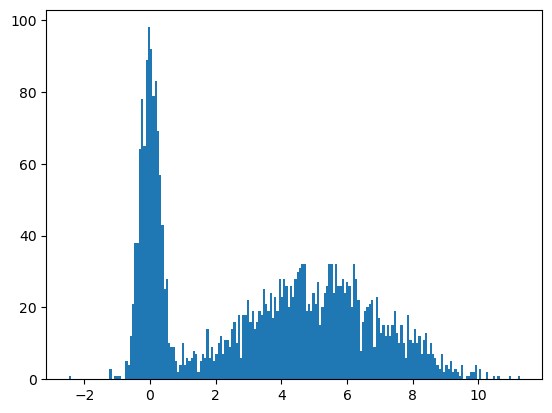

In [2]:
X1 = np.random.normal(size=1000, scale=0.3).astype('float32')
X2 = np.random.normal(size=2000, loc=5., scale=2.).astype('float32')

X = np.concatenate([X1, X2])
np.random.shuffle(X)

plt.hist(X, bins=200);

**Task**:
 - fill the gaps below to perform the max. likelihood fit with the pdf:
$$\text{PDF}(x|\mu_1, \sigma^2_1, \mu_2, \sigma^2_2, \alpha)
= \alpha\cdot\mathscr{N}(x|\mu_1, \sigma_1^2) + (1 - \alpha)\cdot\mathscr{N}(x|\mu_2, \sigma_2^2)$$
 - what the fitted values of $\mu_1, \sigma^2_1, \mu_2, \sigma^2_2$ and $\alpha$ should be? does your fit converge to them?

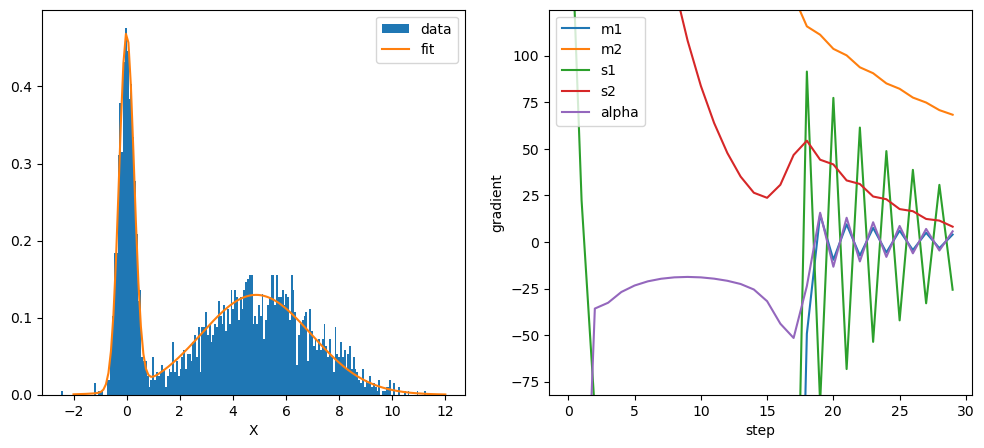

In [3]:
from IPython.display import clear_output

# Defining Gaussian PDF using torch functions
def gaussian(x, mu, sigma):
  normalization = 1 / (sigma * torch.sqrt(torch.tensor(2 * np.pi)))
  exponent = torch.exp(-0.5 * ((x - mu) / sigma) ** 2)
  return normalization * exponent

# Arbitrary mixture PDF
def mixture(x, f1, f2, alpha):
  return alpha * f1(x) + (1. - alpha) * f2(x)

# Parameters that we'd like to infer (with an initial guess)
m1    = torch.tensor([1.0], requires_grad=True)
m2    = torch.tensor([4.0], requires_grad=True)
s1    = torch.tensor([1.0], requires_grad=True)
s2    = torch.tensor([1.0], requires_grad=True)
alpha = torch.tensor([0.5], requires_grad=True)

# At each gradient update we'll apply this function to
# ensure valid parameter values
def apply_constraints():
  with torch.no_grad(): #we do not want to track this in the graph
    s1.clamp_(min=1e-5)
    s2.clamp_(min=1e-5)
    alpha.clamp_(1e-5, 1. - 1e-5) # from 0 to 1 excluding borders

variables = [m1, m2, s1, s2, alpha]

# Defining the overall PDF
def model_pdf(x):
  return mixture(x,
                 lambda t: gaussian(t, m1, s1),
                 lambda t: gaussian(t, m2, s2),
                 alpha)

# Log likelihood
def loglike(x):
  pdf_vals = model_pdf(x)
  return torch.sum(torch.log(pdf_vals + 1e-9))

learning_rate = 0.0001
grad_history = [] # to keep track of gradient values at different steps
for i in range(30):
  # Forward pass:
  l = loglike(torch.tensor(X, requires_grad=True)) 
  
  # Backprop
  l.backward()
  #collect grads
  grads = [v.grad.item() for v in variables]
  grad_history.append(grads)

  # Gradient ascent step
  with torch.no_grad():
    for v in variables:
       v += learning_rate * v.grad
       v.grad.zero_()
  apply_constraints()
  ############################
  # Do some plotting
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.hist(X, bins=200, density=True, label='data')
  x_grid = torch.tensor(np.linspace(-2, 12, 150))
  plt.plot(x_grid, model_pdf(torch.tensor(x_grid)).detach().numpy(), label='fit')
  plt.legend()
  plt.xlabel('X')

  plt.subplot(1, 2, 2)
  lines = plt.plot(np.array(grad_history))
  low = min(grad_history[-1])
  high = max(grad_history[-1])
  plt.ylim(low  - (high - low) * 0.6,
           high + (high - low) * 0.6)
  plt.legend(lines, ['m1', 'm2', 's1', 's2', 'alpha'])
  plt.xlabel('step')
  plt.ylabel('gradient')
  plt.show()
  clear_output(wait=True);

so, we can see that model fited good

# Task 2: classifying clothes (3 points)

In [4]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

[['Ankle boot' 'Sandal' 'Shirt' 'Shirt' 'Shirt' 'Coat' 'Trouser'
  'Trouser']
 ['T-shirt/top' 'Sandal' 'T-shirt/top' 'Sandal' 'Sneaker' 'Bag' 'Dress'
  'Bag']
 ['Sneaker' 'Dress' 'Sneaker' 'Dress' 'Pullover' 'Sneaker' 'Trouser'
  'Ankle boot']
 ['Trouser' 'Dress' 'Dress' 'T-shirt/top' 'Pullover' 'T-shirt/top'
  'Trouser' 'Sandal']
 ['Coat' 'Bag' 'T-shirt/top' 'T-shirt/top' 'Coat' 'Sneaker' 'Pullover'
  'Dress']
 ['T-shirt/top' 'Ankle boot' 'Sandal' 'Dress' 'T-shirt/top' 'Shirt'
  'Coat' 'Sandal']
 ['Sneaker' 'Sandal' 'Dress' 'Ankle boot' 'Sandal' 'Bag' 'Dress' 'Dress']
 ['Bag' 'Trouser' 'Pullover' 'Trouser' 'Trouser' 'Shirt' 'Sneaker'
  'Ankle boot']]


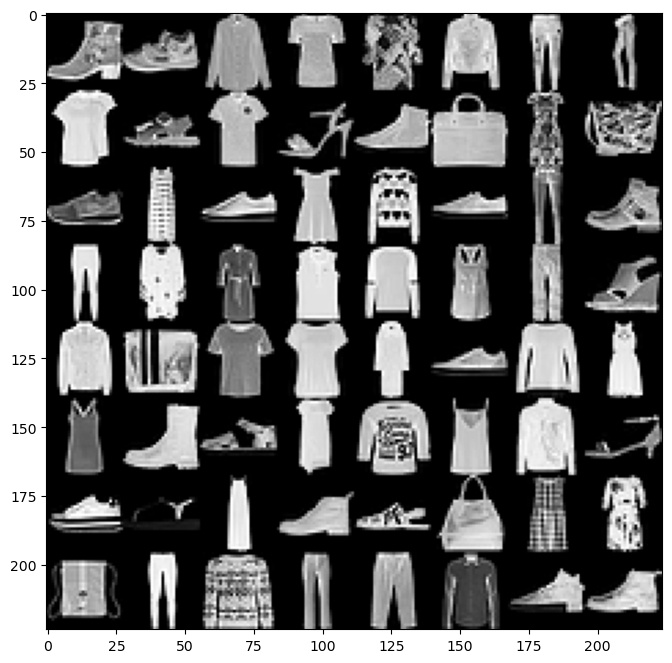

In [5]:
# Array for decoding the categories
label_names = np.array(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle boot'])

# Get a single data batch of 64 images
sample_images, sample_labels = next(iter(trainloader))

# Plot the images in a 8x8 grid
plt.figure(figsize=(8, 8))
plt.imshow(
    sample_images.numpy().reshape(8, 8, 28, 28).transpose((0, 2, 1, 3)).reshape(224, 224),
    cmap='gray'
)
# Print corresponding labels
print(label_names[sample_labels.numpy().reshape(8, 8)])

**Task**:

Train a model which is an average of two models with different numbers of layers on the Fashion MNIST dataset, e.g.:

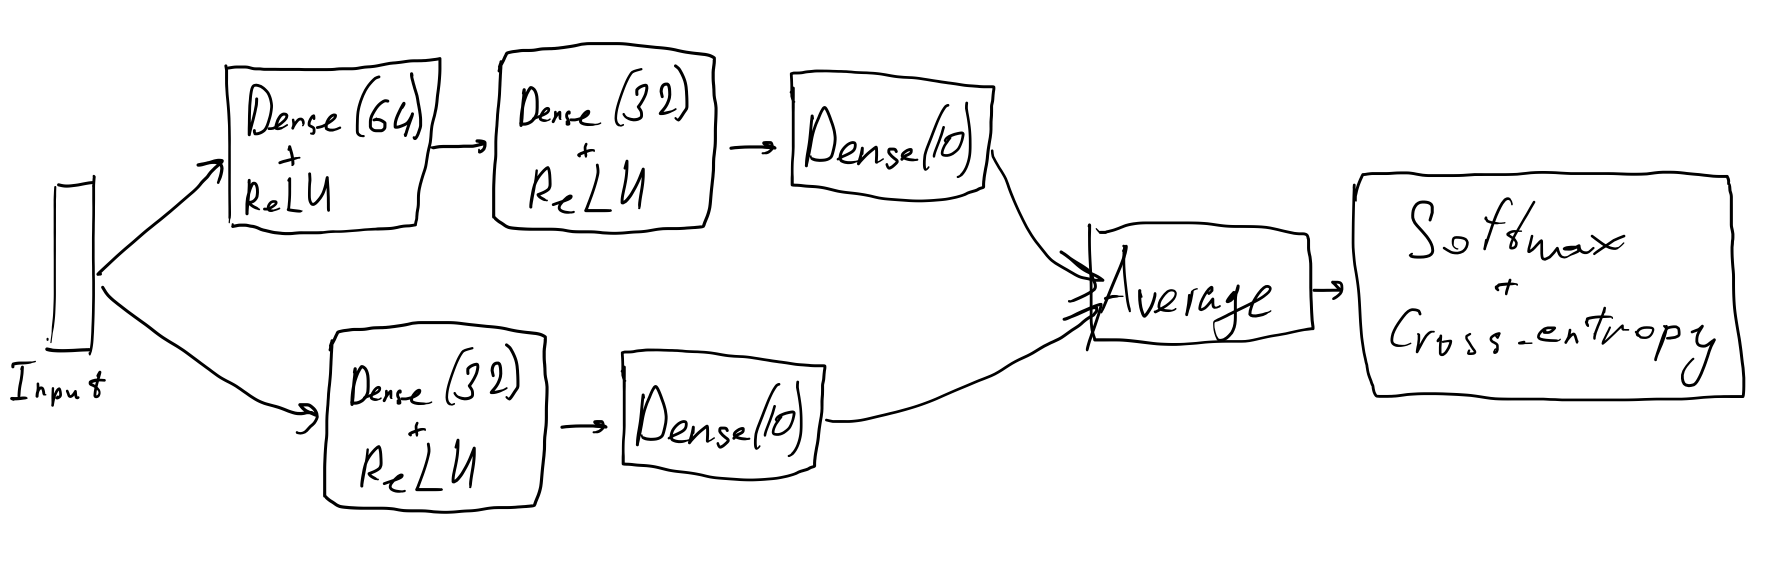

In [6]:
# to check pic size
next(iter(trainloader))[0][0].size()

torch.Size([1, 28, 28])

Let's initialize models

In [13]:
model1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 64), 
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 10),
    nn.ReLU()
)

model2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 32),
    nn.ReLU(),
    nn.Linear(32, 10),
    nn.ReLU(),
)


In [14]:
# let's optimize our nn using SGD, we make dynamic LR
initial_lr = 0.05
optimizer1 = optim.SGD(model1.parameters(), initial_lr)
optimizer2 = optim.SGD(model2.parameters(), initial_lr)
scheduler1 = StepLR(optimizer1, step_size=8, gamma=0.5)
scheduler2 = StepLR(optimizer2, step_size=8, gamma=0.5)


Let's train our model in 15 epochs

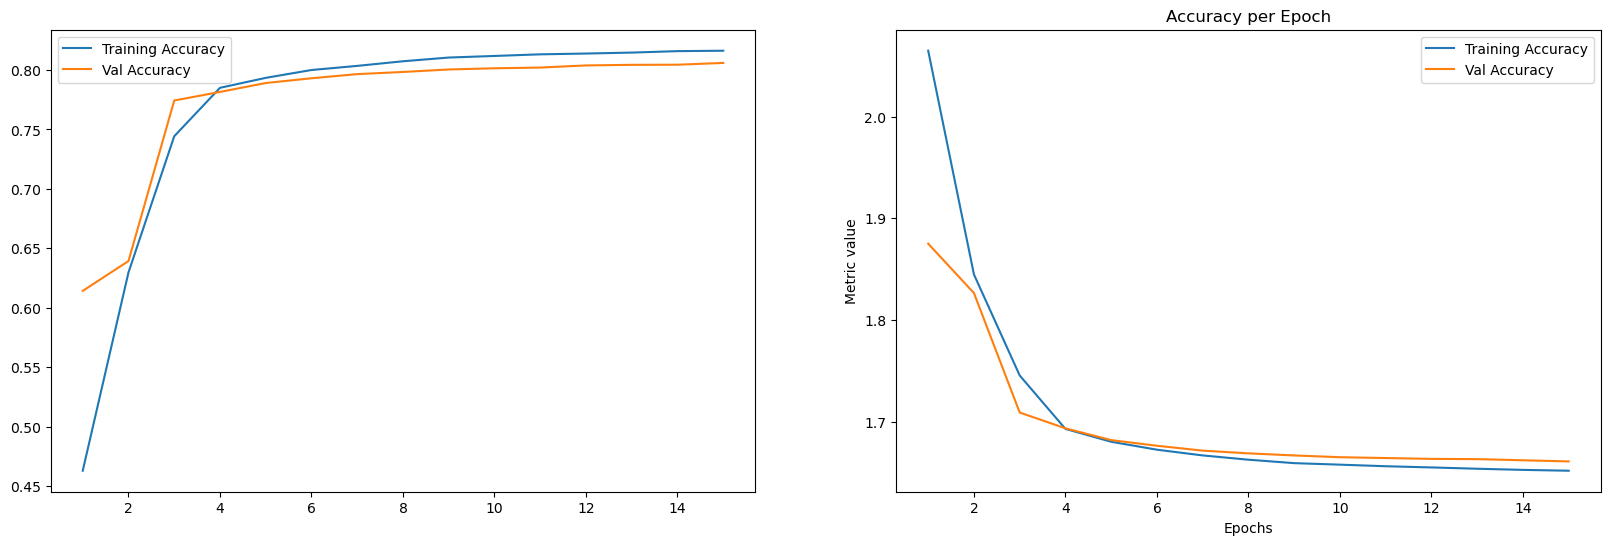

train loss: 1.6518208296822587, train accuracy: 0.8161666666666667, val loss: 1.6609621237797343, val accuracy: 0.8059


In [15]:
n_epochs = 15
train_accuracies = []
val_accuracies = [] 
train_losses = [] 
val_losses = []

for epoch in range(n_epochs):
    #train
    train_loss = []
    train_acc = []
    for X_train, y_train in trainloader:
        model1.train()
        model2.train()

        y_pred1 = model1(X_train)
        y_pred2 = model2(X_train)

        y_avg = (y_pred1 + y_pred2) / 2.0
        softmax_output = F.softmax(y_avg, dim=1)
        loss = F.cross_entropy(softmax_output, y_train)
        loss.backward()
        optimizer1.step()
        optimizer2.step()
        optimizer1.zero_grad()
        optimizer2.zero_grad()


        #collect metrics 
        train_loss.append(loss.item())
        train_acc.extend(
            (torch.argmax(softmax_output, dim=-1) == y_train).numpy().tolist()
        )
    # val
    val_loss = []
    val_acc = []
    with torch.no_grad():
        for X_val, y_val in testloader:
            model1.eval()
            model2.eval()
            y_pred1 = model1(X_val)
            y_pred2 = model2(X_val)

            y_avg = (y_pred1 + y_pred2) / 2.0
            softmax_output = F.softmax(y_avg, dim=1)
            loss = F.cross_entropy(softmax_output, y_val)

            val_loss.append(loss.item())
            val_acc.extend(
                (torch.argmax(softmax_output, dim=-1) == y_val).numpy().tolist()
            )
    scheduler1.step()
    scheduler2.step()

    train_accuracies.append(np.mean(train_acc))
    val_accuracies.append(np.mean(val_acc))
    train_losses.append(np.mean(train_loss))
    val_losses.append(np.mean(val_loss))

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

    ax1.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy')
    ax1.plot(range(1, epoch + 2), val_accuracies, label='Val Accuracy')
    ax2.plot(range(1, epoch + 2), train_losses, label='Training Accuracy')
    ax2.plot(range(1, epoch + 2), val_losses, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Metric value')
    plt.title('Accuracy per Epoch')
    ax1.legend()
    ax2.legend()
    plt.show()
    if epoch != n_epochs - 1:
        clear_output(wait=True)
print(
f"train loss: {np.mean(train_loss)}, train accuracy: {np.mean(train_acc)}, val loss: {np.mean(val_loss)}, val accuracy: {np.mean(val_acc)}"
)


So, we can see, that results are not bad, also judging by plots, model is not overfitted.